In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# custom package
import plotting_tools as pt
%matplotlib inline

from matplotlib.patches import Ellipse
from scipy.stats import norm
from scipy import stats

# this is a module I created
from cluster_methods import *

from sklearn import decomposition
import skfuzzy as fuzz
from sklearn import preprocessing
from sklearn import manifold

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

import kcorrect

from scipy import linalg

import cluster_methods
from sklearn.mixture import GMM
    
# exploring the properties of galaxies through multidimensional statistical analysis techniques 
# vespa data, galaxy zoo data, sdss
# 0: stellar mass
# 1: error
# 2: SFR last 115 Myr
# 3: dustVal ISM
# 4: metallicity
# 5: redshift
# 6: prob. elliptical
# 7: prob. spiral
# 8: prob. merger
# 9: u
# 10: g
# 11: r
# 12: i
# 13: z
# 14: u err
# 15: g err
# 16: r err
# 17: i err
# 18: z err
# 19: petro r
# 20: theta
# 21: specObjID

# preprocessing, k-corrections, normalising data, cluster analysis

In [17]:
def kernel_density_estimation(x,y):
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return xx,yy,f

In [18]:
kcorrect.load_templates()
kcorrect.load_filters()

def perform_kcorrect(redshift,magnitudes,mag_ivars):
    # remember to apply AB magnitude offsets if required
    maggies = pow(10,-0.4*np.array(magnitudes))
    maggies_ivar = pow(0.4*np.log(10)*maggies*np.array(mag_ivars),-2)
    c = kcorrect.fit_nonneg(redshift,maggies,maggies_ivar)
    rm = kcorrect.reconstruct_maggies(c)
    rm0 = kcorrect.reconstruct_maggies(c,redshift=0.)
    return -2.5*np.log10(rm[1:]/rm0[1:])   

In [19]:
# load galaxies
galaxies = np.load('/home/calum/Documents/Mphys_data/vespa_data/final_vespa_properties.npy')
galaxies.shape

(417322, 21)

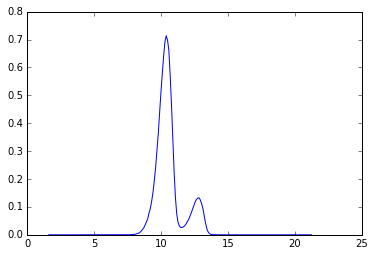

In [20]:
pt.plot_hist([np.log10(row[1]) for row in galaxies],200,'mass errors')

In [21]:
rlim_galaxies = np.array([row for row in galaxies if 0.08>row[5]>0.004])
rlim_galaxies.shape

(137166, 21)

In [22]:
# plot un kcorrected CMD and remove obvious outliers
x = [(row[19])-5*(np.log10(cosmo.luminosity_distance(row[5]).to(u.pc).value/10)) for row in rlim_galaxies]
y = [row[9]-row[11] for row in rlim_galaxies]

In [23]:
len(x)

137166

(-23, -16)

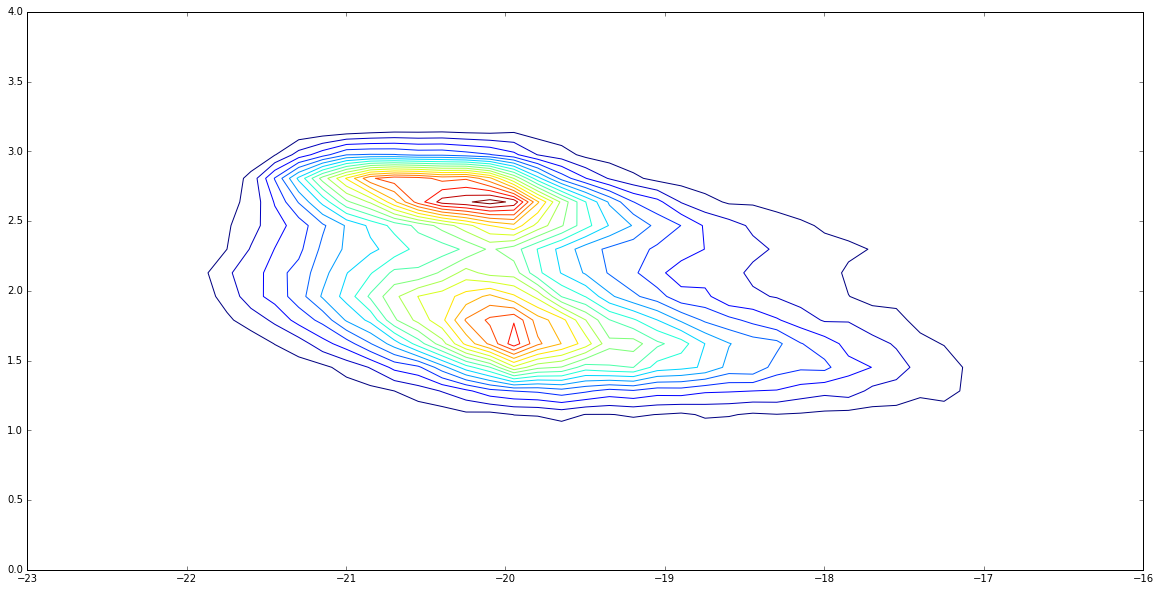

In [24]:
plt.figure(figsize=(20,10))
pt.plot_contour(x,y,bins=70)
plt.ylim(0.,4.)
plt.xlim(-23,-16)

In [25]:
kcorrections = []

for row in rlim_galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[5],row[9:14],row[14:19])
    # store k-corrections
    kcorrections.append([row[5],ktuple]) 

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([row[0] for row in kcorrections],[row[1][0] for row in kcorrections],'k+')

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([row[0] for row in kcorrections],[row[1][2] for row in kcorrections],'k+')

In [ ]:
len(y), len(kcorrections)

In [ ]:
kcorrect_y = []
kcorrect_x = []

for i,row in enumerate(y):
    kcorrect_x.append(x[i]-kcorrections[i][1][2])
    kcorrect_y.append(row-kcorrections[i][1][0]+kcorrections[i][1][2])

In [ ]:
plt.figure(figsize=(20,10))
pt.plot_contour(kcorrect_x,kcorrect_y,bins=70)
plt.plot(kcorrect_x,kcorrect_y,'+')
plt.ylim(1.,3.5)
plt.xlim(-22.5,-16.5)

In [ ]:
plt.figure(figsize=(20,10))
pt.plot_hist(kcorrect_y,200,'k-corrections')
pt.plot_hist(y,200,'no k-corrections')
plt.legend()

In [ ]:
# remove outliers, only removes 500 obvious outliers
reduced_rlim_galaxies = []

for i, row in enumerate(rlim_galaxies):
    if 0.5 < kcorrect_y[i] < 3.6:
        reduced_rlim_galaxies.append(row)    
            
len(reduced_rlim_galaxies)

In [ ]:
# do kcorections again
kcorrections = []

for row in reduced_rlim_galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[5],row[9:14],row[14:19])
    # store k-corrections
    kcorrections.append([row[5],ktuple]) 

In [ ]:
# define dataset
data = []

# [row[0],row[1],row[6],row[7],row[10]

#create dataset for clustering
for i,row in enumerate(reduced_rlim_galaxies):
    # absolute r-band petrosian magnitude
    x0 = float(row[19])-5*(np.log10(cosmo.luminosity_distance(row[5]).to(u.pc).value/10))-kcorrections[i][1][2]
    # k-corrected (u-r) colour
    x1 = row[9]-row[11]-kcorrections[i][1][0]+kcorrections[i][1][2]
    # redshift
    x2 = row[4]
    # morphological parameters
    x3 = 0
    x4 = 0
    x5 = 0
    if row[6] > 0.8:
        x3 = 1            
    if row[7] > 0.8:
        x4 = 1
    if row[8] > 0.8:
        x5 = 1
    # ISM dust value
    x6 = row[3]
    # log(stellar mass)
    x7 = np.log(row[0])
    # SFR last 115 Myr
    x8 = row[2]
    # metallicity average in last 5 age bins (115 Myr)
    x9 = row[4]
    # surface brightness
    x10 = row[19]+2.5*np.log10(2*np.pi*row[20]*row[20])
        
    # append to data
    data.append([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])

In [ ]:
data = np.array(data)
data.shape

In [ ]:
plt.figure(figsize=(20,10))
pt.plot_contour([row[0] for row in data],[row[1] for row in data],bins=30)
plt.plot([row[0] for row in data],[row[1] for row in data],'+')

In [ ]:
# scale data before manifold learning
# select rows that will be used for clustering
data_clustering = [ [row[0],row[1],row[3],row[4],row[5],row[6],row[7],row[10]] for row in data]
data_scaled = preprocessing.scale(data_clustering)

In [ ]:
plt.figure(figsize=(20,10))
#pt.plot_contour([row[0] for row in data_scaled[sample_number]],[row[1] for row in data_scaled[sample_number]],bins=30)
pt.plot_contour([row[0] for row in data_scaled],[row[1] for row in data_scaled],bins=30)
#plt.plot([row[0] for row in data_scaled[sample_number]],[row[1] for row in data_scaled[sample_number]],'+')

In [ ]:
sample_number = np.random.choice(np.array([i for i  in range(0,171992)]),21499)

In [56]:
sample_number[:10]

array([ 65265, 115690, 121730,   9602, 133887,  66782,  45774, 130371,
        57574,  84954])

In [57]:
# use manifold learning technique Modified Locally Linear Embedding
lle = manifold.LocallyLinearEmbedding(n_neighbors=12,n_components=4)

In [58]:
lle.fit_transform(data_scaled[sample_number])

IndexError: index 157779 is out of bounds for axis 0 with size 136810

In [ ]:
lle_data = lle.transform(data_scaled)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([row[2] for row in lle_data],[row[3] for row in lle_data],'+')

In [ ]:
pca = decomposition.PCA(n_components=4)

In [ ]:
data_pca = pca.fit_transform(data_scaled)

In [ ]:
plt.figure(figsize=(20,10))
i = 2
j = 3
pt.plot_contour([row[i] for row in data_pca],[row[j] for row in data_pca])
plt.plot([row[i] for row in data_pca],[row[j] for row in data_pca],'+')

In [2]:
# perform fuzzy cluster analysis
#np.save('/home/calum/Documents/Mphys_data/vespa_data/datadat.npy',data)
#np.save('/home/calum/Documents/Mphys_data/vespa_data/data_scaled.npy',data_scaled)
data_scaled = np.load('/home/calum/Documents/Mphys_data/vespa_data/data_scaled.npy')
data = np.load('/home/calum/Documents/Mphys_data/vespa_data/datadat.npy')


In [3]:
data_scaled.shape

(136810, 8)

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


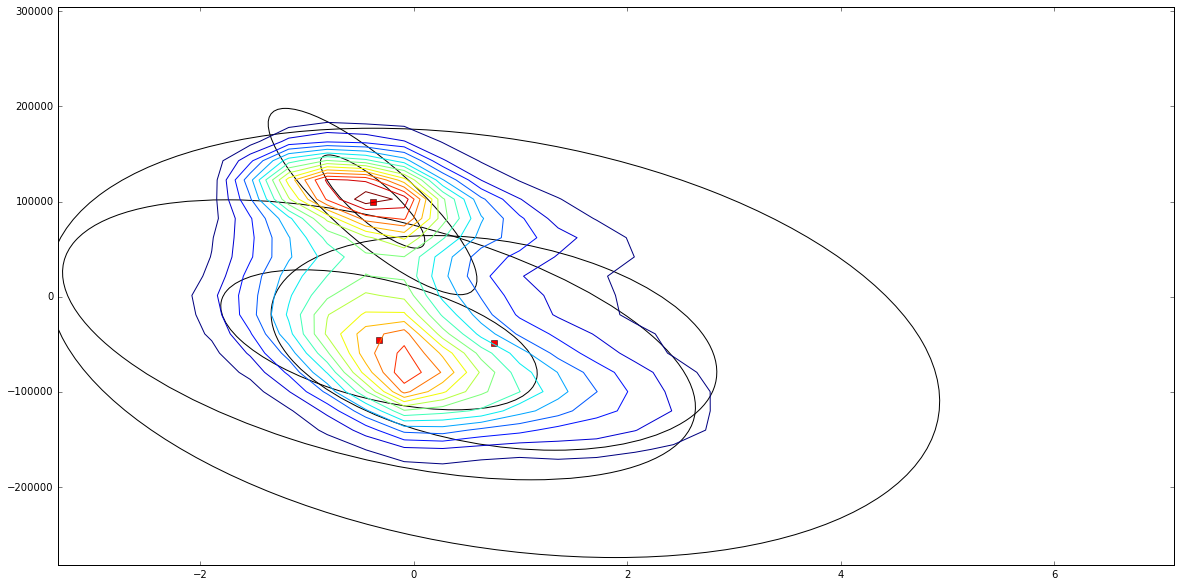

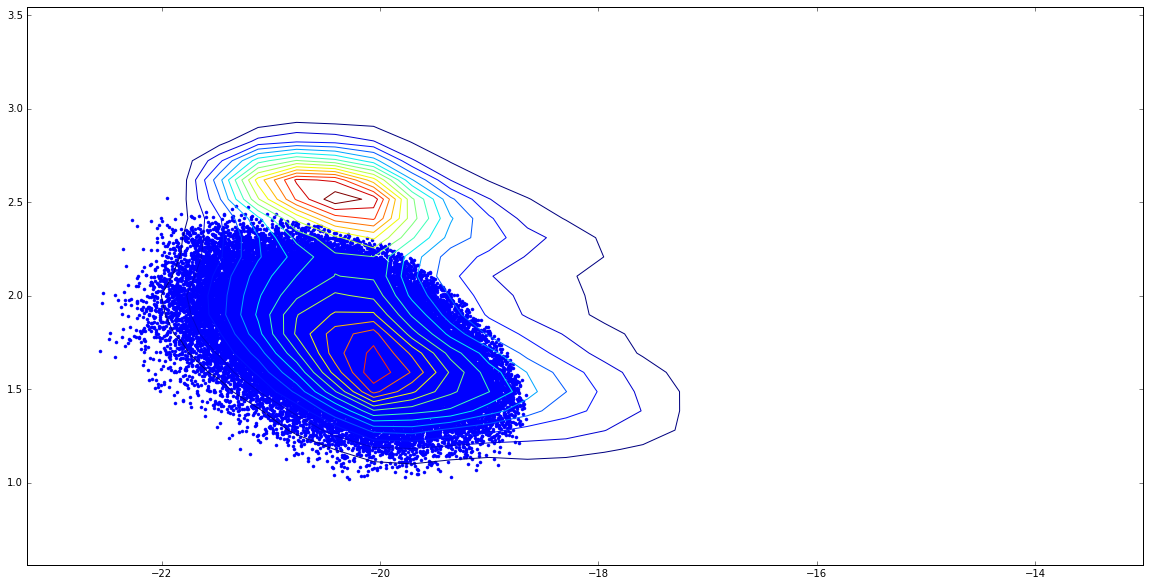

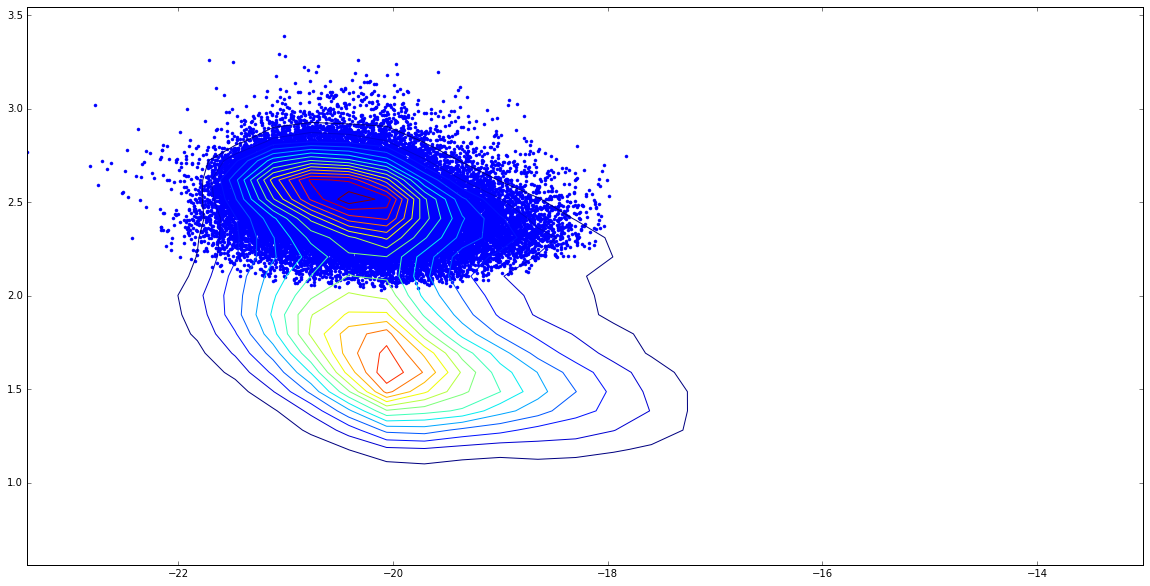

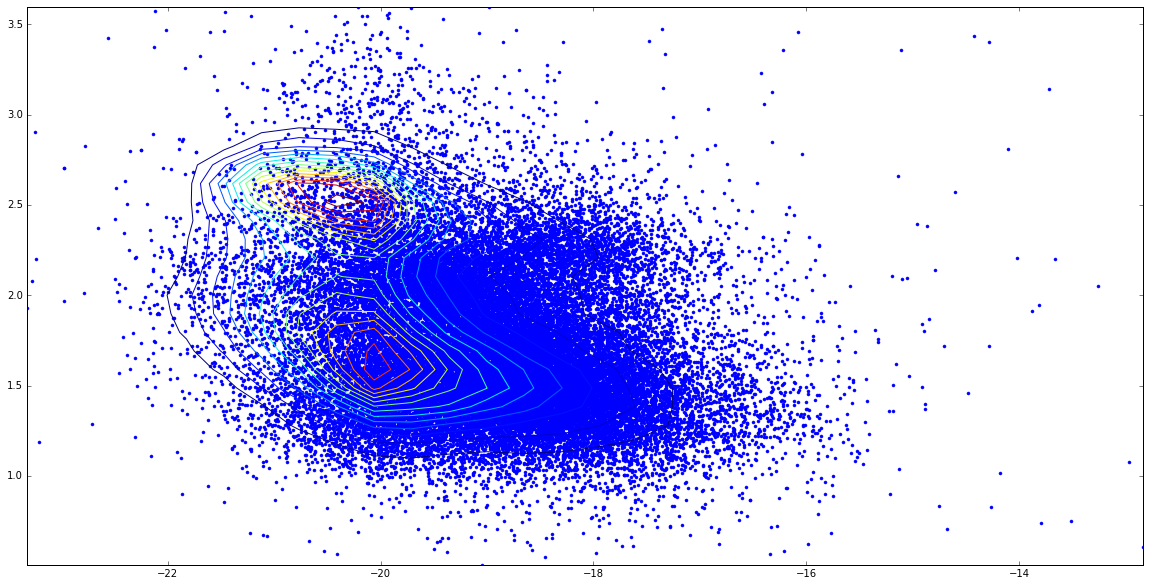

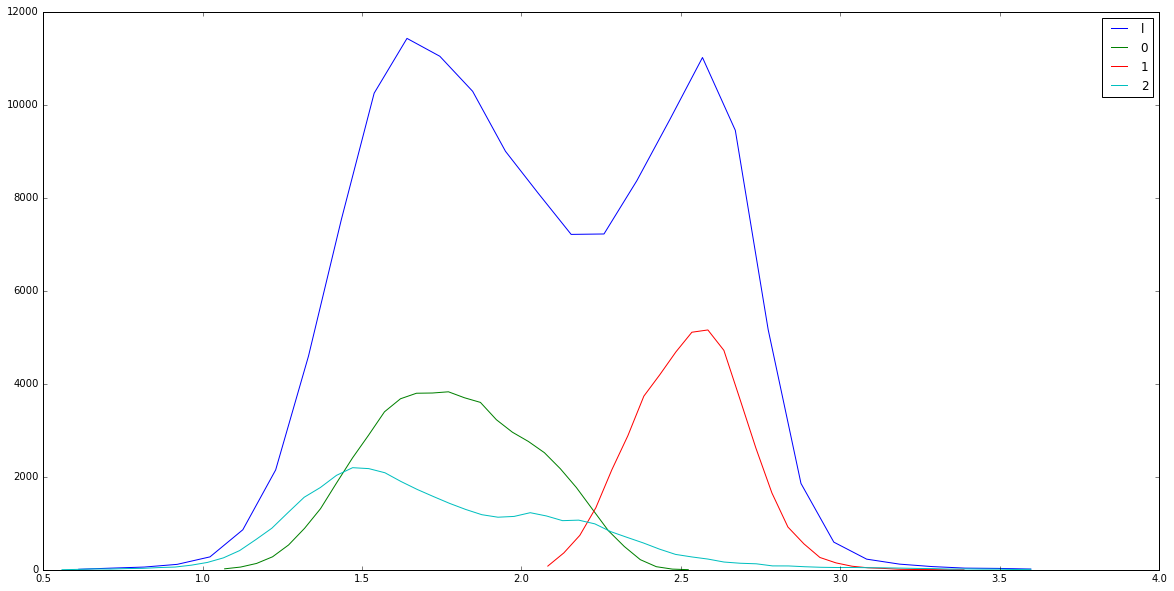

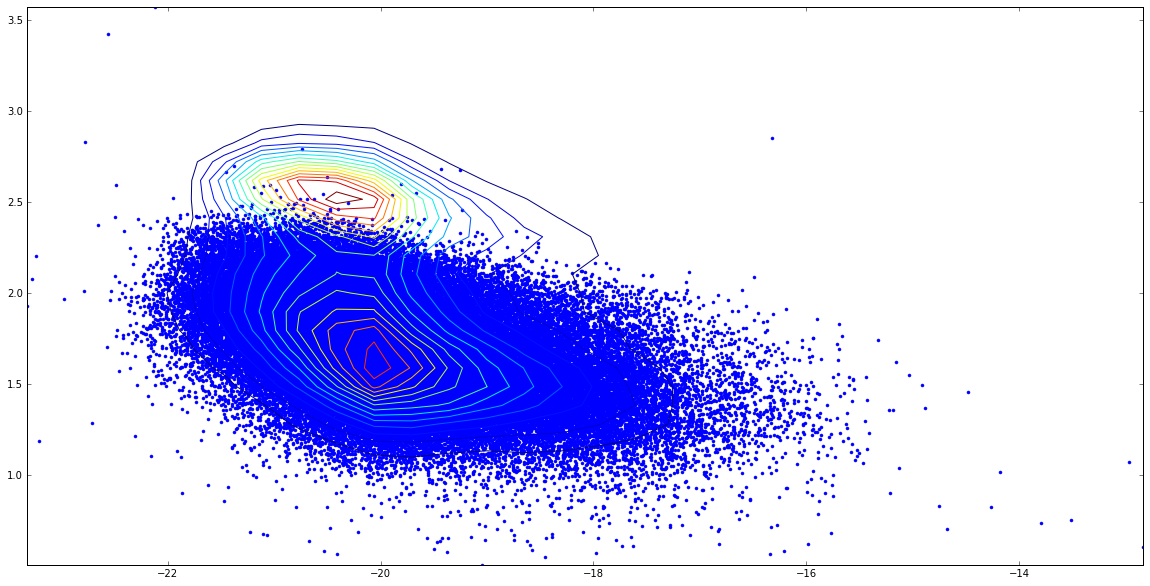

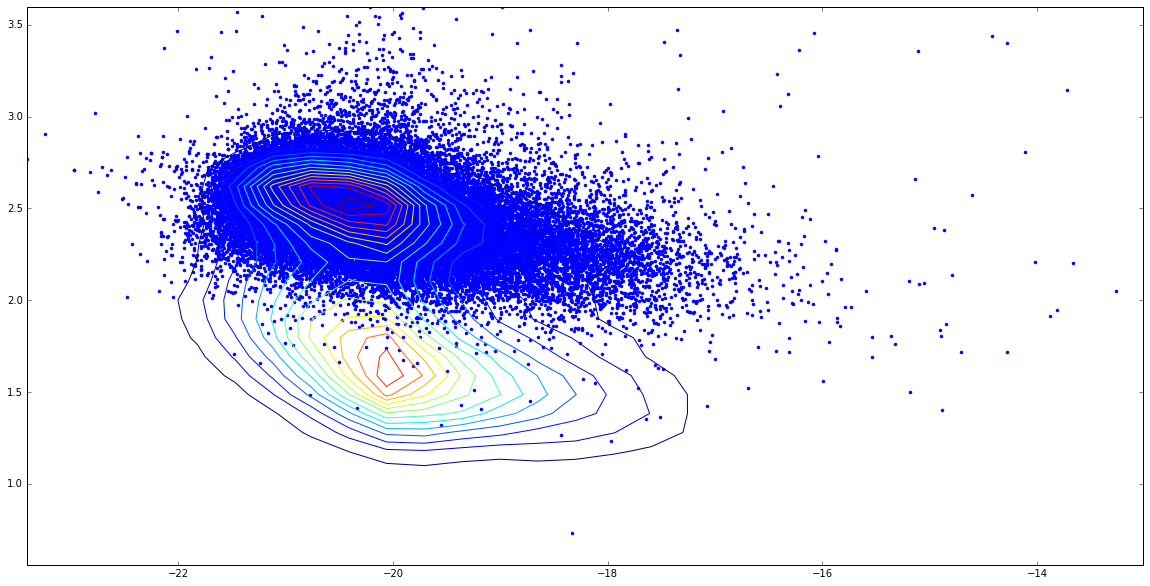

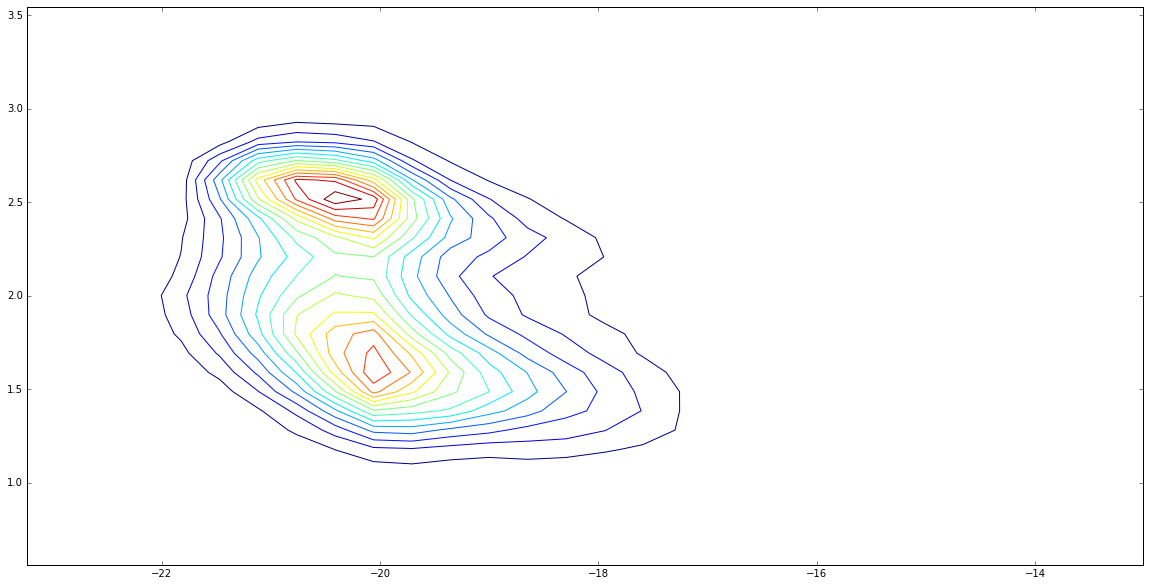

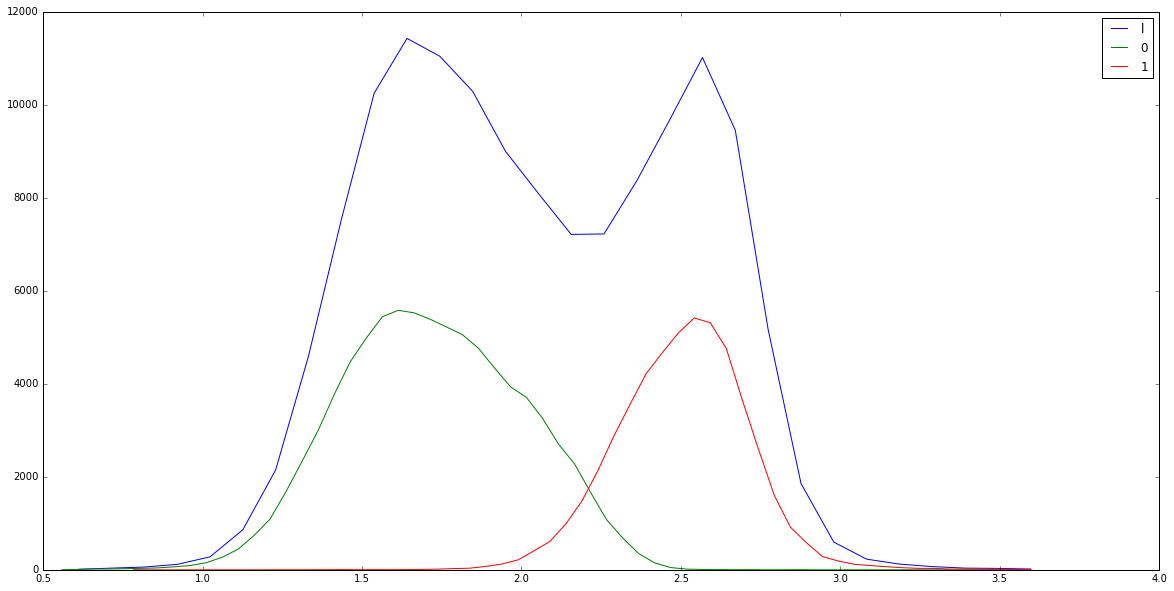

In [4]:
cluster_probs, gmm = cluster_methods.gmm_clustering(data,[[row[0],row[1]*90000,row[6],row[7]] for row in data_scaled],3,500,'mc','full')

In [5]:
clusters_zero = []

for row in cluster_probs:
    if row[0] > 0.1 and row[0] < .8  and row[1] > 0.1 and row[1] < .8:
        clusters_zero.append(1)
    else:
        clusters_zero.append(0)
        
clusters_zero = np.array(clusters_zero) 


cluster_membership = np.argmax(cluster_probs.T[:2], axis=0)

cluster_probs_excluding_green_valley = np.argmax(cluster_probs[clusters_zero==0].T[1:],axis=0)



In [6]:
x = np.array([row[0] for row in data])
y = np.array([row[1] for row in data])

(1, 4)

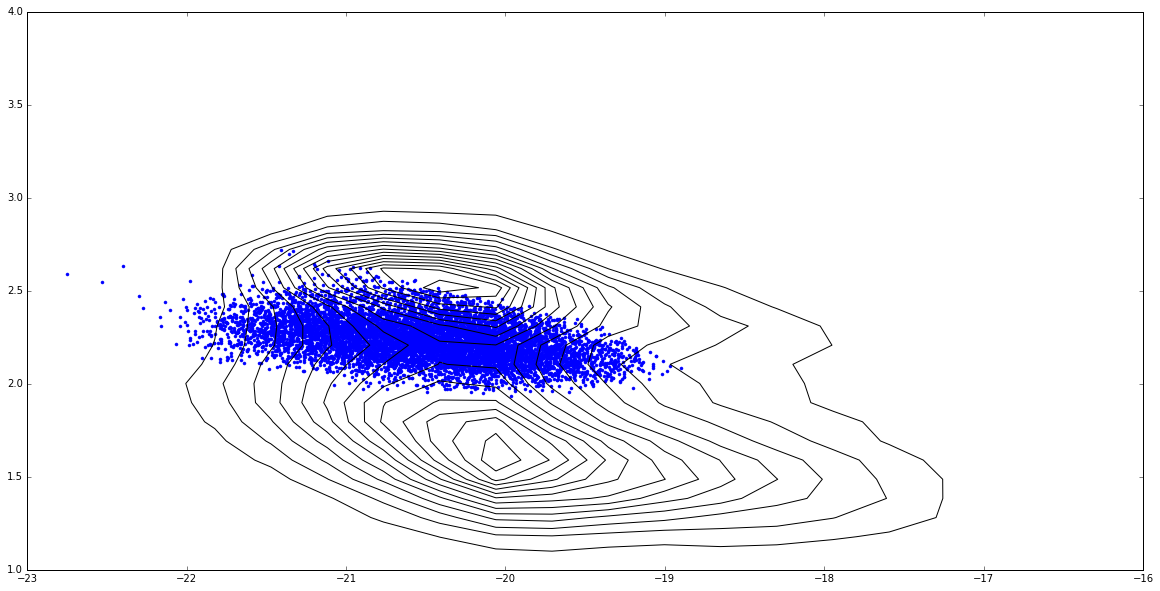

In [7]:
plt.figure(figsize=(20,10))

pt.plot_contour(x,y,colours='k')
plt.plot(x[clusters_zero == 1],y[clusters_zero == 1],'.')
#plt.plot(x[clusters_one == 1],y[clusters_one == 1],'.')
#pt.plot_contour(x[clusters_zero == 1],y[clusters_zero == 1])
#pt.plot_contour(x[clusters_one == 1],y[clusters_one == 1])

plt.xlim(-23,-16)
plt.ylim(1,4)

In [8]:
np.mean([row[1] for row in cluster_probs])

0.31902213874332819

In [9]:
x1 = []
y1 = []

for i,row in enumerate(y):
    if cluster_membership[i] == 0:
        if clusters_zero[i] == 0:
            y1.append(row)
            x1.append(x[i])
x2 = []            
y2 = []

for i,row in enumerate(y):
    if cluster_membership[i] == 1:
        if clusters_zero[i] == 0:
            y2.append(row)
            x2.append(x[i])
            
bluex = []
bluey = []
blue_data = []

for i,row in enumerate(y):
    if cluster_membership[i] == 0:
        bluey.append(row)
        bluex.append(x[i])
        blue_data.append(data[i])
        
redx = []            
redy = []
red_data = []

for i,row in enumerate(y):
    if cluster_membership[i] == 1:
        redy.append(row)
        red_data.append(data[i])
        redx.append(x[i])

In [10]:
def plot_hist(array,bin_num,label,normed=True,set_bin_size=False,bin_size=1,colour='b',alt='norm'):
    """Histogram plotter made by me, versatile"""
    if set_bin_size == True:
        bin_num = float(np.max(array)-np.min(array))/bin_size
        n, bins = np.histogram(array,bins=int(bin_num),normed=normed)
    else:
        n, bins = np.histogram(array,bins=bin_num,normed=normed)
    if alt == 'bluey':
        plt.plot(bins[1:],n,'--',linewidth=3,color=colour)
    else:
        plt.plot(bins[1:],n,label=label,drawstyle='steps-mid',linewidth=3,color=colour)
    return 

(array([    0.,   500.,  1000.,  1500.,  2000.,  2500.]),
 <a list of 6 Text yticklabel objects>)

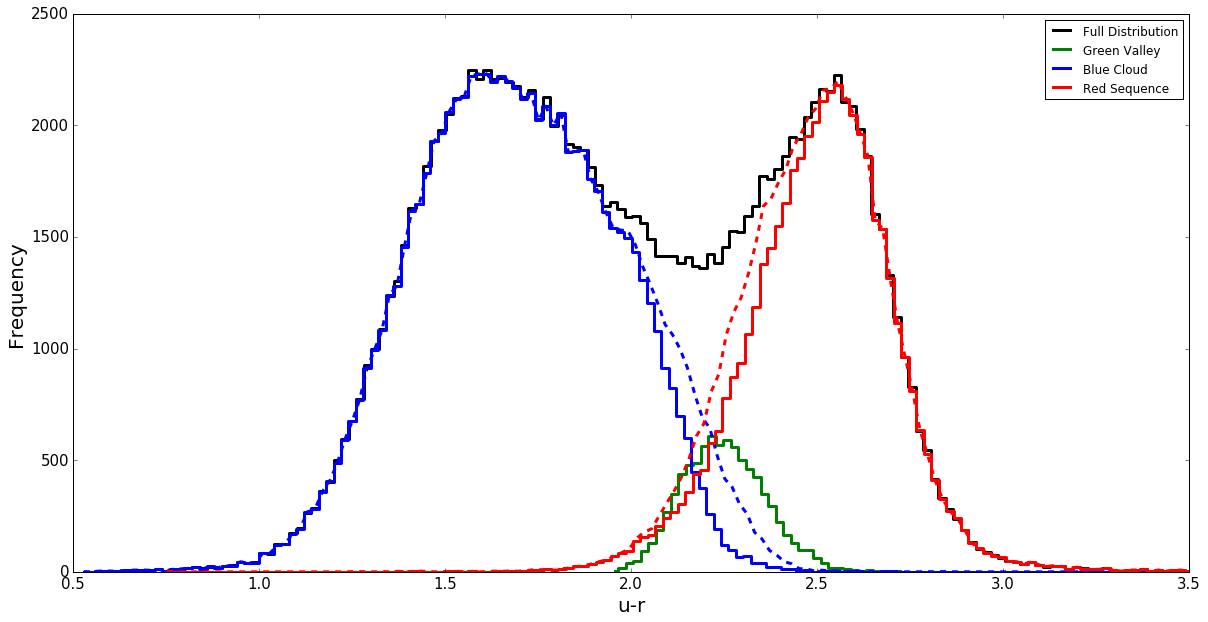

In [14]:
plt.figure(figsize=(20,10))
plot_hist(y,200,'Full Distribution',set_bin_size=True,bin_size=0.02,normed=False,colour='k')
#pt.plot_hist(y[clusters_one == 1],200,'cluster one',set_bin_size=True,bin_size=0.05,normed=False)
plot_hist(y[clusters_zero == 1],200,'Green Valley',set_bin_size=True,bin_size=0.02,normed=False,colour='g')

#for i in range(2):
#    pt.plot_hist(y[cluster_membership==i],200,str(i),set_bin_size=True,bin_size=0.05,normed=False)

plot_hist(y1,200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b')
plot_hist(bluey,200,'Blue Cloud',set_bin_size=True,bin_size=0.02,normed=False,colour='b',alt='bluey')
plot_hist(redy,200,'Redsequence',set_bin_size=True,bin_size=0.02,normed=False,colour='r',alt='bluey')

plot_hist(y2,200,'Red Sequence',set_bin_size=True,bin_size=0.02,normed=False,colour='r')
#plot_hist(redy,200,str(i),set_bin_size=True,bin_size=0.05,normed=False)
#plot_hist(bluey,200,str(i),set_bin_size=True,bin_size=0.05,normed=False)

plt.xlim(0.5,3.5)
plt.xlabel('u-r',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [12]:
def kernel_density_estimation(x,y):
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)
    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    return xx,yy,f

In [13]:
x = np.array([row[0] for row in data])
y = np.array([row[1] for row in data])
xx,yy,f = kernel_density_estimation(x,y)

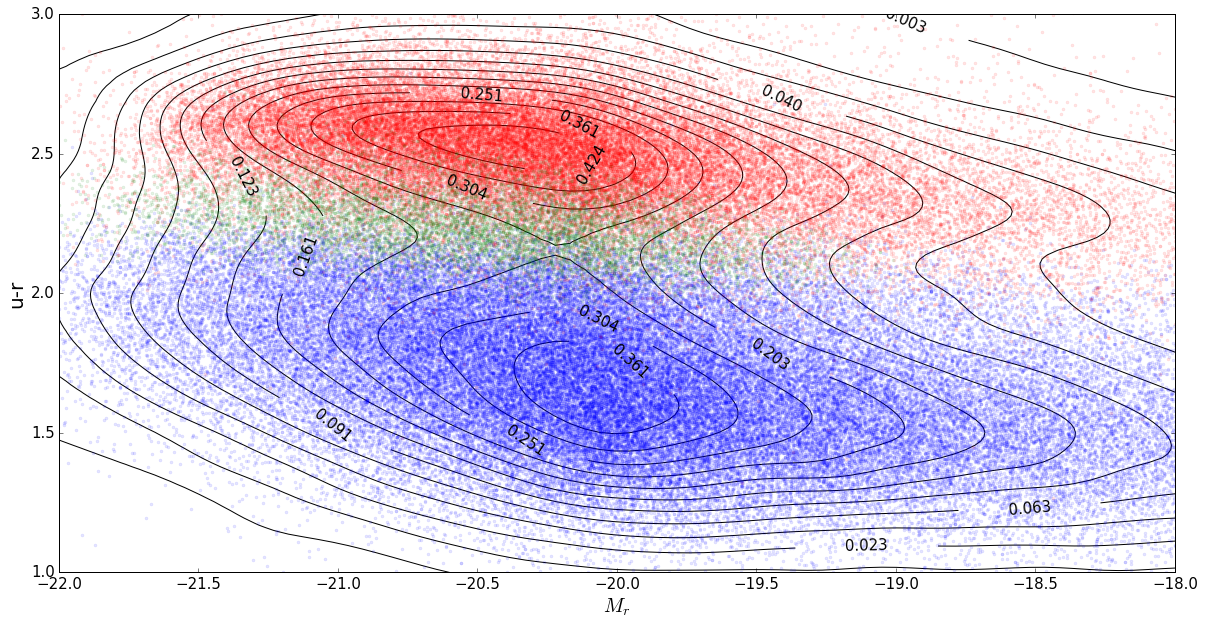

In [29]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
# Contourf plot
#cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.95,0.05)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.05)], colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=15)
ax.set_ylabel('u-r',fontsize=20)
ax.set_xlabel('$M_{r}$',fontsize =20)
ax.set_ylim(1,3)
ax.set_xlim(-22,-18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(x1,y1,'b.',alpha=0.1)
plt.plot(x2,y2,'r.',alpha=0.1)
plt.plot(x[clusters_zero == 1],y[clusters_zero == 1],'g.',alpha=0.1)

(0.5, 3.5)

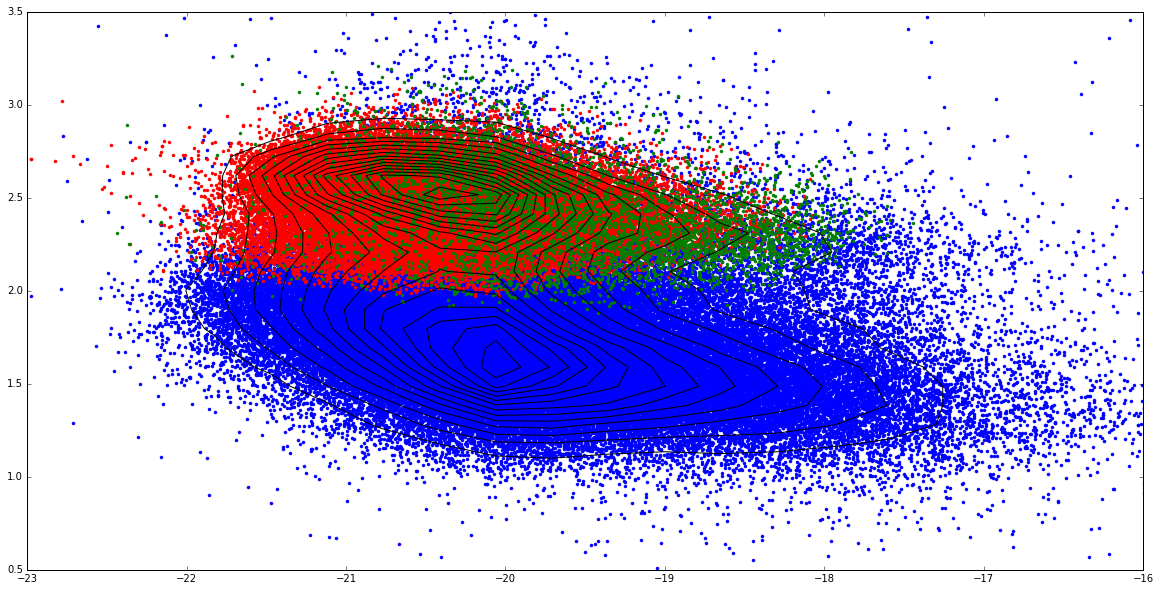

In [33]:
plt.figure(figsize=(20,10))

pt.plot_contour(x,y,colours='k')
plt.plot(x2,y2,'b.')
plt.plot(x1,y1,'r.')
plt.plot(x[clusters_zero == 1],y[clusters_zero == 1],'g.')

plt.xlim(-23,-16)
plt.ylim(0.5,3.5)

In [117]:
import scipy.stats as st

xmin, xmax = -23,-16
ymin, ymax = 0.5,3.5

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

In [118]:
yy[1][2],yy[2][2]

(0.53015075376884424, 0.53015075376884424)

In [768]:
y90 = []
x90 = []

by90 = []
bx90 = []

for i,row in enumerate(cluster_probs):
    if row[0] > 0.5:
        x90.append(x[i])
        y90.append(y[i])
    if row[1] > 0.5:
        bx90.append(x[i])
        by90.append(y[i])  

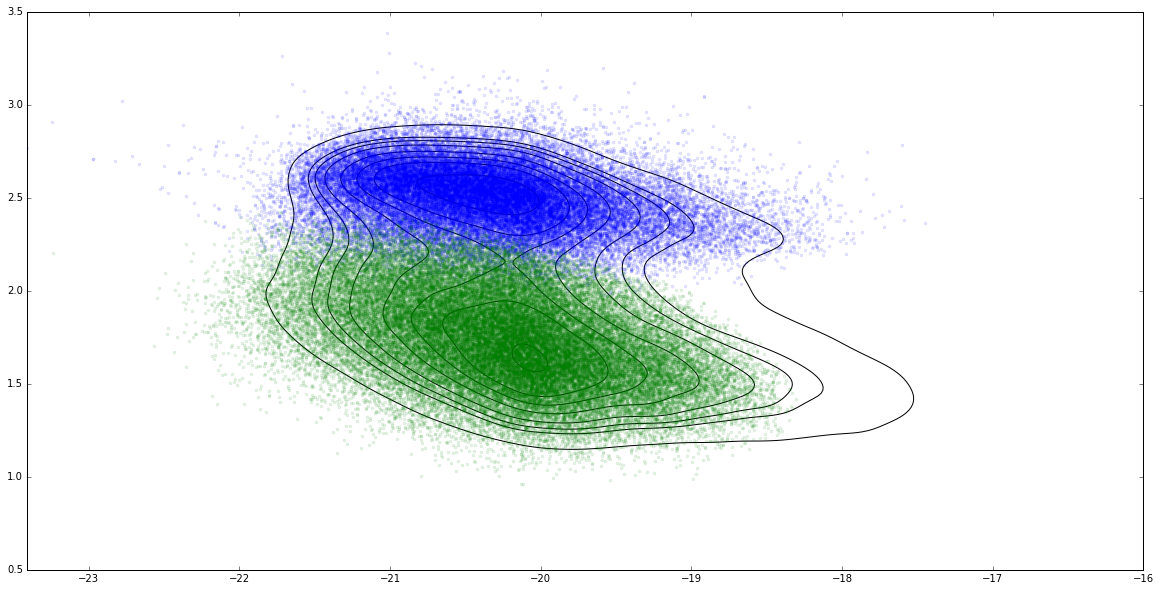

In [769]:
plt.figure(figsize=(20,10))
plt.plot(x90,y90,'.',alpha=0.1)
plt.plot(bx90,by90,'.',alpha=0.1)
plt.contour(xx, yy, f, colors='k',alpha=1.,levels=[0.05,0.1,0.12,0.15,0.2,0.25,0.3,0.4])


In [745]:
x90,y90

([-19.204859869108212,
  -19.776357282353999,
  -19.583225092128878,
  -19.800343800861661,
  -20.118386081932861,
  -21.661462232131647],
 [2.3513124063611031,
  2.249477818608284,
  2.4189443811774254,
  2.356082871556282,
  2.270685575902462,
  2.2227602303028107])

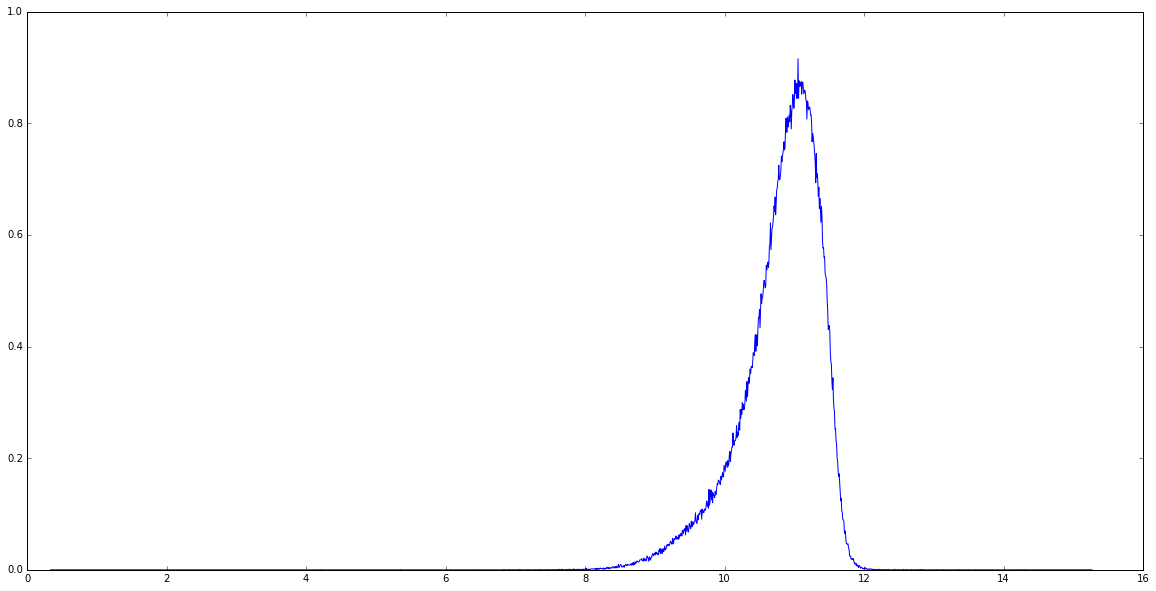

In [48]:
plt.figure(figsize=(20,10))
pt.plot_hist([np.log10(row[0]) for row in galaxies],2000,'stellar mass')

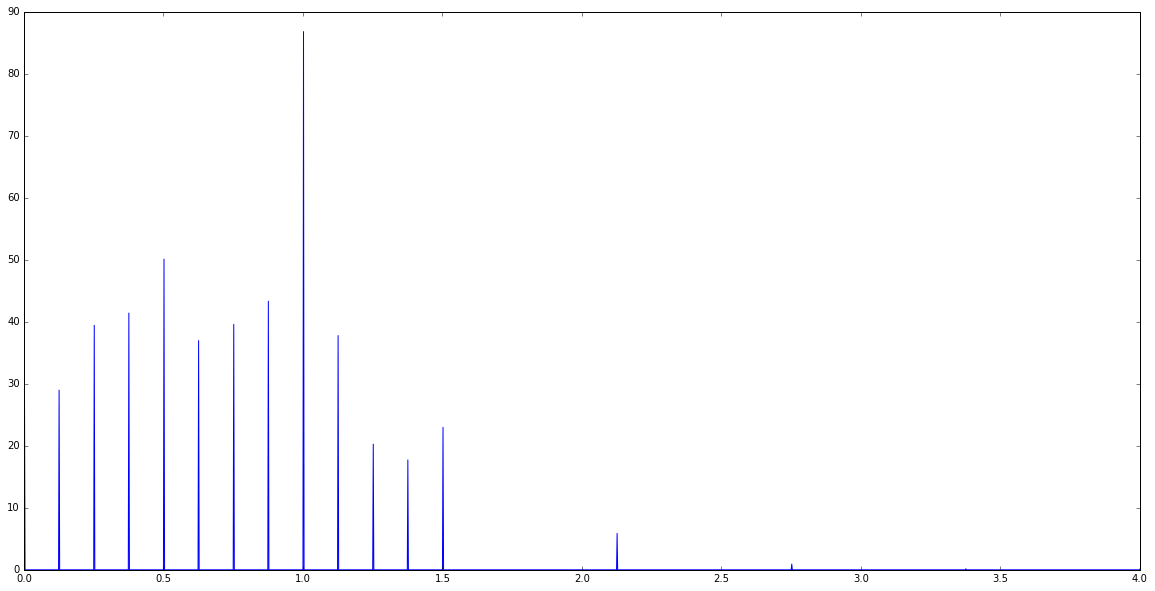

In [51]:
plt.figure(figsize=(20,10))
pt.plot_hist([row[3] for row in galaxies],2000,'ISM dust')

In [62]:
np.min([row[2] for row in galaxies])

0.0

In [64]:
np.max([row[2] for row in galaxies])

16545738260869.564

In [63]:
np.mean([row[2] for row in galaxies])

1546070973.0345771

In [65]:
len([row[2] for row in galaxies if row[2]< 1546070973.0345771]),len([row[2] for row in galaxies if row[2] > 1546070973.0345771])

(353245, 64077)

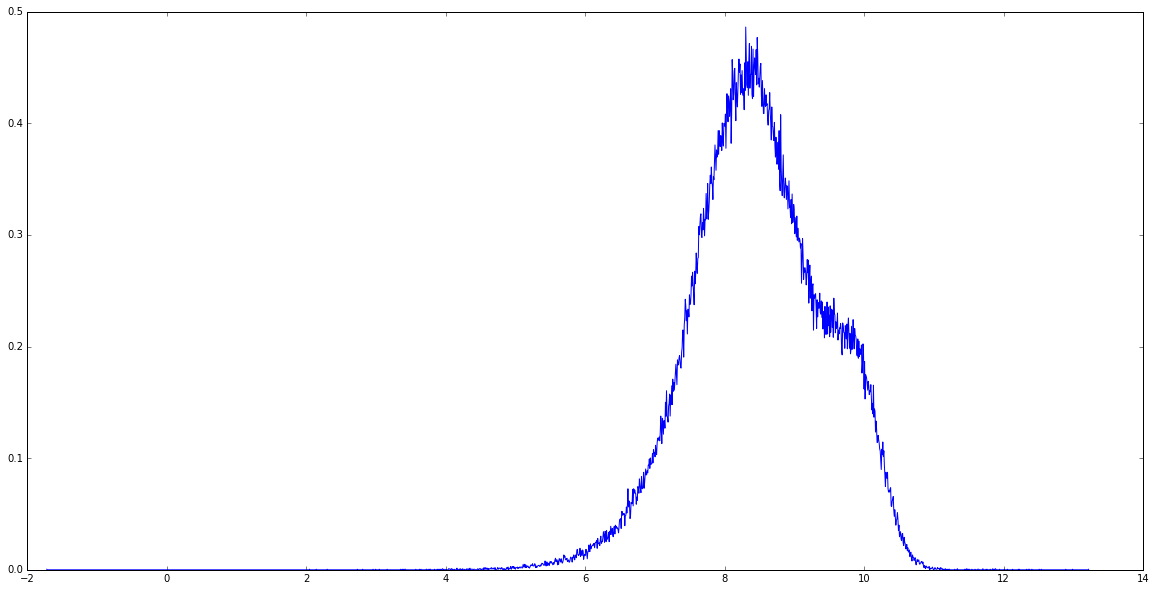

In [70]:
plt.figure(figsize=(20,10))
pt.plot_hist([np.log10(row[2]) for row in galaxies if row[2]!=0],2000,'SFR')

271026

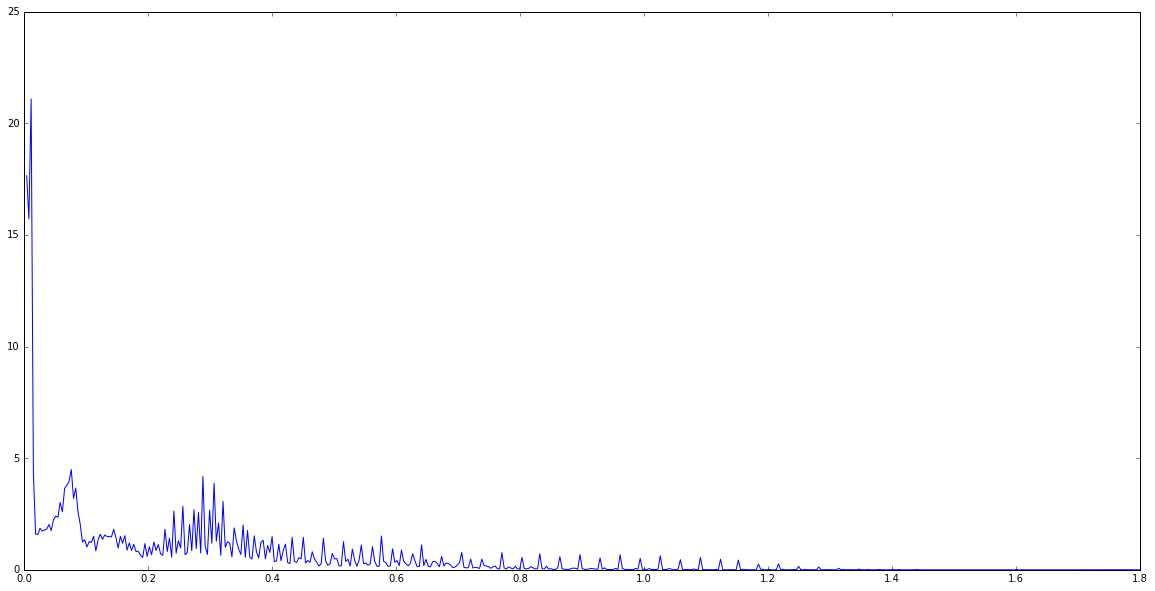

In [108]:
plt.figure(figsize=(20,10))
pt.plot_hist([row[4] for row in galaxies if row[4]!=0],500,'ISM dust')
len([np.log(row[4]) for row in galaxies if row[4]!=0])

In [118]:
x = np.array([row[0] for row in data])
y = np.array([row[1] for row in data]) 
xx,yy,f = kernel_density_estimation(x,y)

(array([ 1. ,  1.5,  2. ,  2.5,  3. ]), <a list of 5 Text yticklabel objects>)

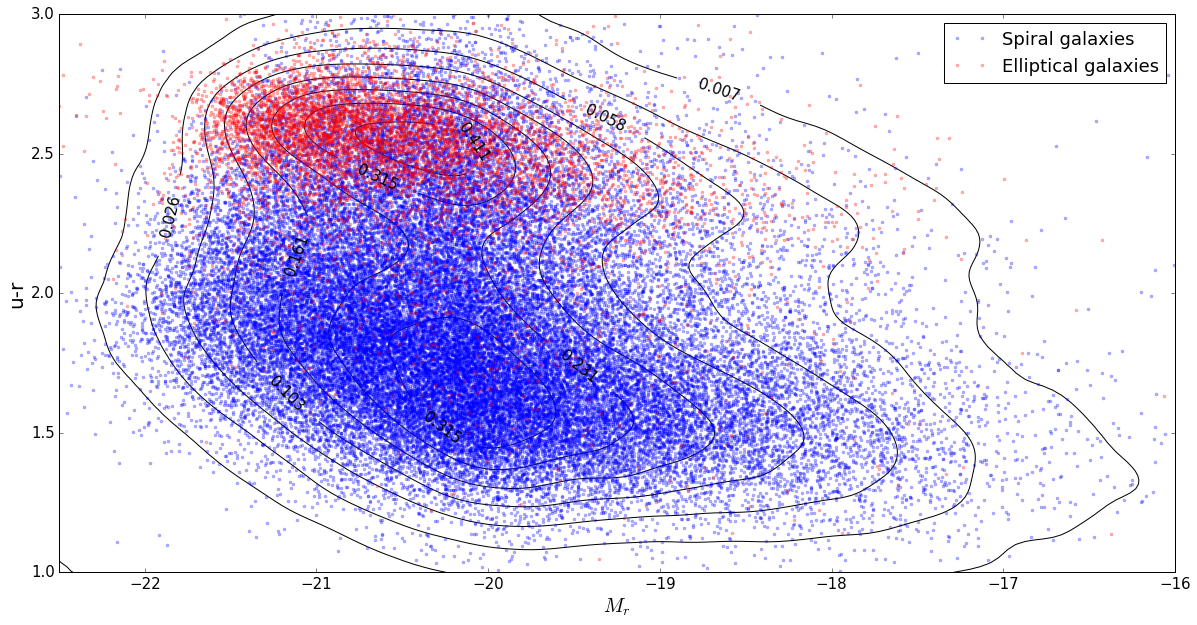

In [32]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
nxx = xx
nyy = yy
nf = f
# Contourf plot
#cfset = ax.contourf(nxx, nyy, nf,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.08)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(nxx, nyy, nf,levels=[np.power(x,2) for x in np.arange(0.001,1.2,0.08)],colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=15)
ax.set_ylabel('u-r',fontsize=20)
ax.set_xlabel('$M_{r}$',fontsize=20)
ax.set_ylim(1,3.)
ax.set_xlim(-22.5,-16)
plt.plot([row[0] for row in data if row[4] == 1],[row[1] for row in data if row[4] == 1],'b.',alpha=0.3,label='Spiral galaxies')
plt.plot([row[0] for row in data if row[3] == 1],[row[1] for row in data if row[3] == 1],'r.',alpha=0.3,label='Elliptical galaxies')
plt.legend(fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#plt.plot([row[0] for row in data if row[5] == 1],[row[1] for row in data if row[5] == 1],'.',alpha=0.5)

In [34]:
mass_x = np.array([row[7] for row in data])
massur_y = np.array([row[1] for row in data]) 
mass_xx,massur_yy,massf = kernel_density_estimation(mass_x,massur_y)

(array([ 1. ,  1.5,  2. ,  2.5,  3. ]), <a list of 5 Text yticklabel objects>)

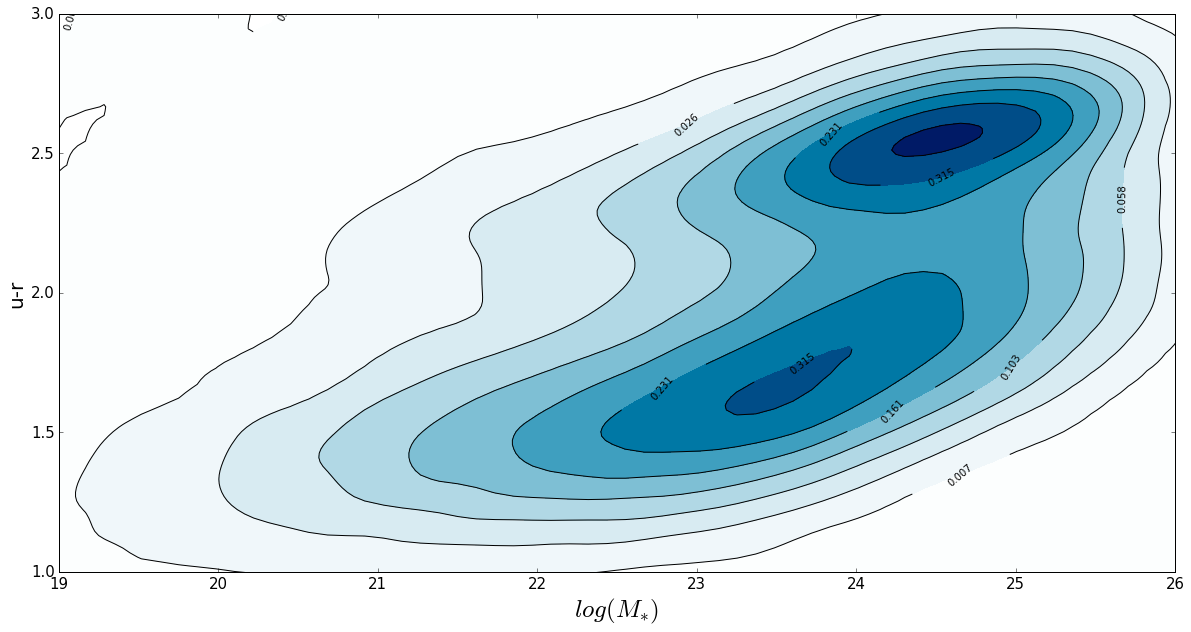

In [36]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
nxx = mass_xx
nyy = massur_yy
nf = massf
# Contourf plot
cfset = ax.contourf(nxx, nyy, nf,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.08)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(nxx, nyy, nf,levels=[np.power(x,2) for x in np.arange(0.001,1.2,0.08)],colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_ylabel('u-r',fontsize=20)
ax.set_xlabel('$log(M_{*})$',fontsize=25)
ax.set_ylim(1,3.)
ax.set_xlim(19,26)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [108]:
x = np.array([row[0] for row in data if row[8]!=0])
y = np.array([row[1] for row in data if row[8]!=0]) 
xx,yy,f = kernel_density_estimation(x,y)

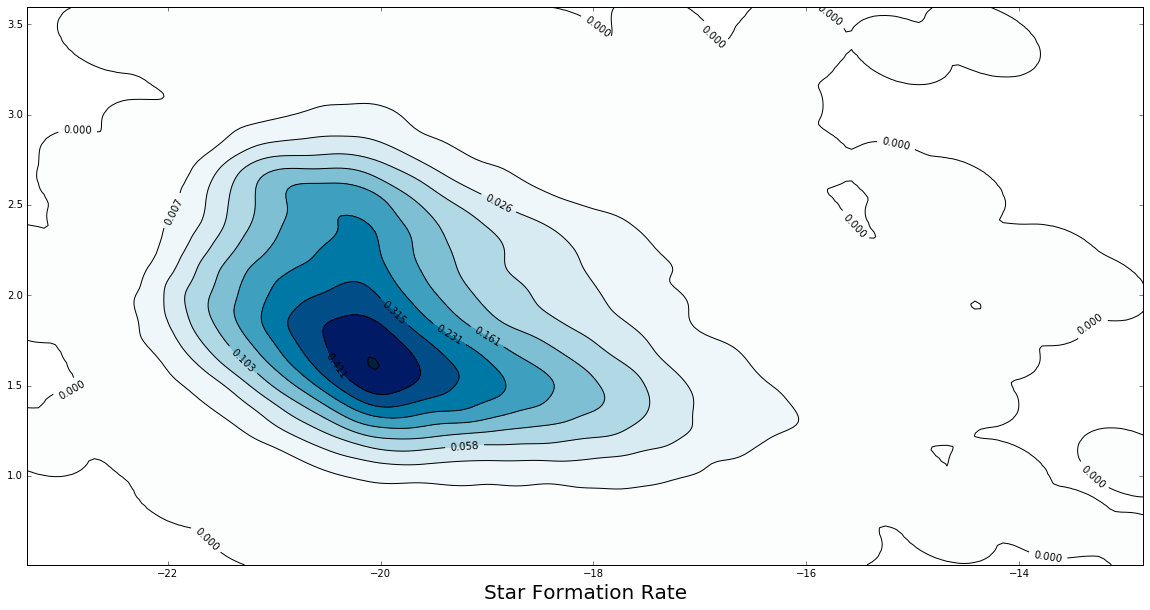

In [109]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
xx = xx
yy = yy
f = f
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.08)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,1.2,0.08)],colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_ylabel('',fontsize=20)
ax.set_xlabel('Star Formation Rate',fontsize=20)
#ax.set_ylim(2,4.8)
#ax.set_xlim(-25.5,-21.7)

In [106]:
sfr_x = np.array([np.log10(row[8]) for row in data if row[8]!=0])
sfrur_y = np.array([row[1] for row in data if row[8]!=0]) 
sfr_xx,sfrur_yy,sfrf = kernel_density_estimation(sfr_x,sfrur_y)

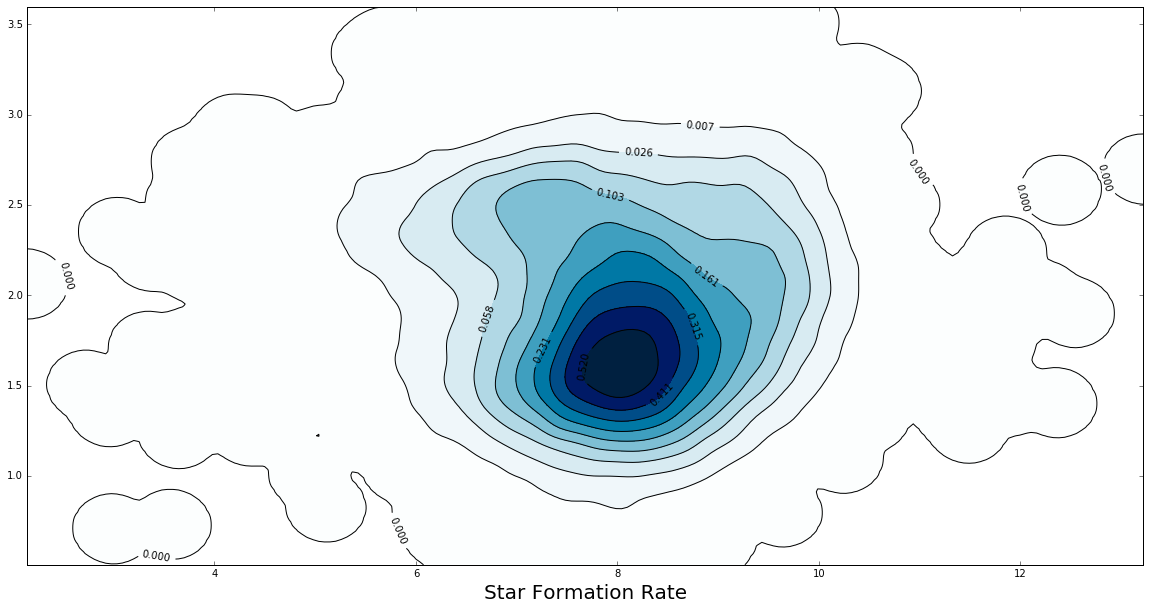

In [107]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
nxx = sfr_xx
nyy = sfrur_yy
nf = sfrf
# Contourf plot
cfset = ax.contourf(nxx, nyy, nf,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.08)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,1.2,0.08)],colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_ylabel('',fontsize=20)
ax.set_xlabel('Star Formation Rate',fontsize=20)
#ax.set_ylim(2,4.8)
#ax.set_xlim(-25.5,-21.7)

In [97]:
Z_x = np.array([np.log10(row[9]) for row in data if row[9]!=0])
Zur_y = np.array([row[1] for row in data if row[8]!=0]) 
Z_xx,Zur_yy,Zf = kernel_density_estimation(Z_x,Zur_y)

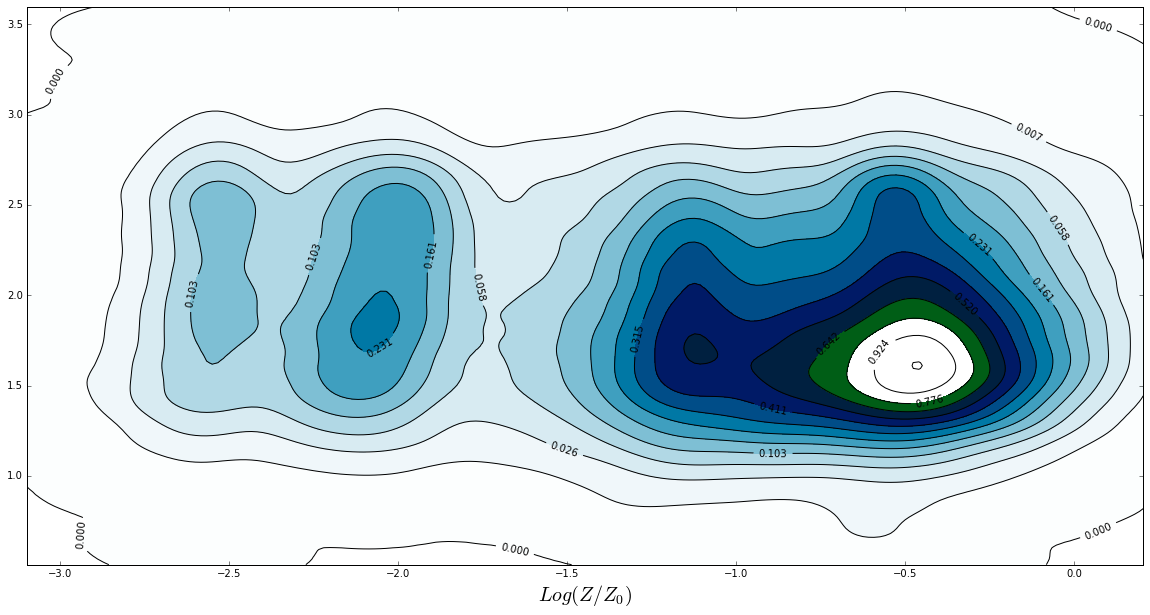

In [99]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
xx = Z_xx
yy = Zur_yy
f = Zf
# Contourf plot
cfset = ax.contourf(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,0.9,0.08)], cmap='ocean_r',)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f,levels=[np.power(x,2) for x in np.arange(0.001,1.2,0.08)],colors='k',alpha=1.)
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_ylabel('',fontsize=20)
ax.set_xlabel('$Log(Z/Z_{0})$',fontsize=20)
#ax.set_ylim(2,4.8)
#ax.set_xlim(-25.5,-21.7)

(array([  6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ]),
 <a list of 9 Text yticklabel objects>)

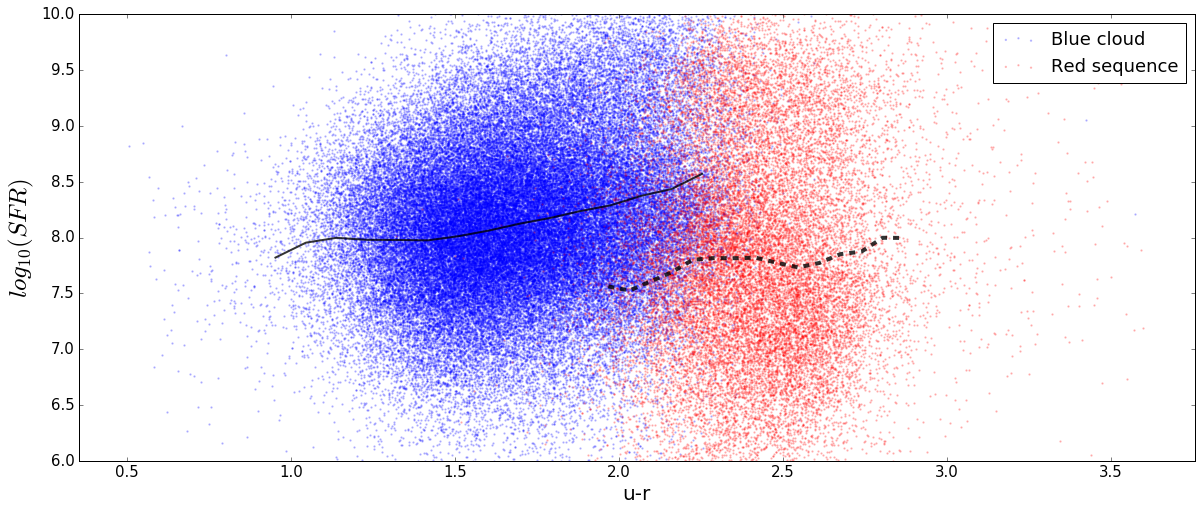

In [39]:
total_bins = 15

# Sample data
Y = np.array([np.log10(row[8]) for row in blue_data if row[8]!=0])
X = np.array([row[1] for row in blue_data if row[8]!=0]) 

bins = np.linspace(1,2.3, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X,bins)
running_median = [np.mean(Y[idx==k]) for k in range(total_bins)]

plt.figure(figsize=(20,8))
plt.scatter(X,Y,color='b',alpha=.2,s=2,label='Blue cloud')
plt.plot(bins-delta/2,running_median,'k',lw=2,alpha=.8)
plt.axis('tight')


# Sample data
Y = np.array([np.log10(row[8]) for row in red_data if row[8]!=0])
X = np.array([row[1] for row in red_data if row[8]!=0]) 

bins = np.linspace(2,2.9, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X,bins)
running_median = [np.mean(Y[idx==k]) for k in range(total_bins)]

plt.scatter(X,Y,color='r',alpha=.2,s=2,label='Red sequence')
plt.plot(bins-delta/2,running_median,'k--',lw=4,alpha=.8)
plt.axis('tight')
plt.ylim(6,10)
#plt.ylim(0,1)
plt.xlabel('u-r',fontsize=20)
plt.ylabel('$log_{10}(SFR)$',fontsize=25)
plt.legend(fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

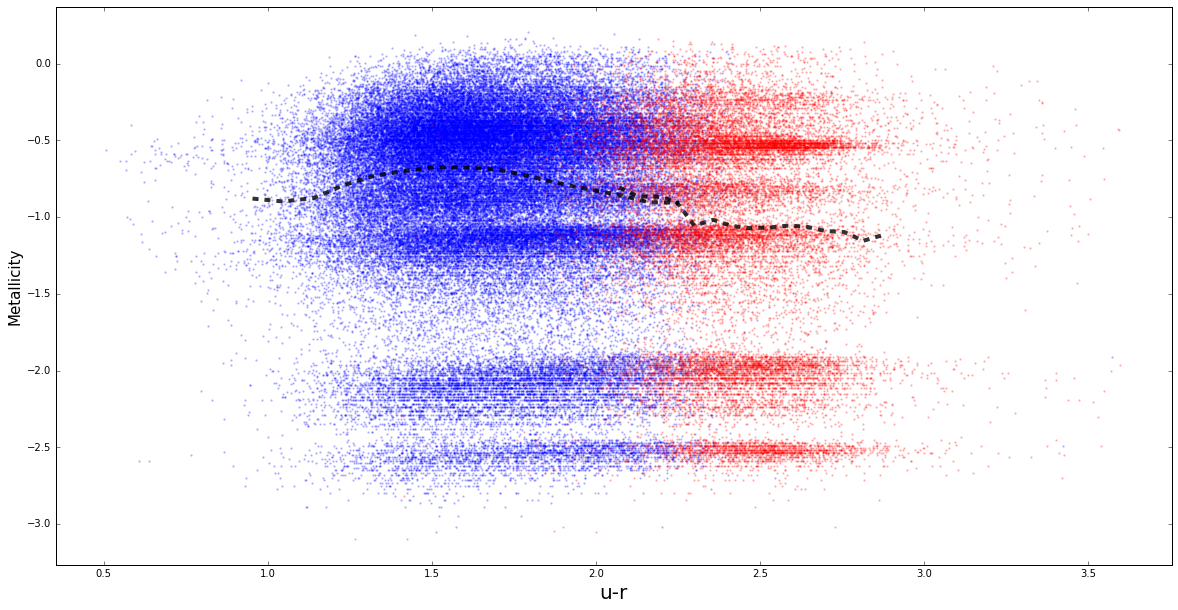

In [111]:
total_bins = 15

# Sample data
Y = np.array([np.log10(row[9]) for row in blue_data if row[9]>0.])
X = np.array([row[1] for row in blue_data if row[9]>0.]) 

bins = np.linspace(1,2.3, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X,bins)
running_median = [np.median(Y[idx==k]) for k in range(total_bins)]

plt.figure(figsize=(20,10))
plt.scatter(X,Y,color='b',alpha=.2,s=2)
plt.plot(bins-delta/2,running_median,'k--',lw=4,alpha=.8)
plt.axis('tight')
#plt.ylim(6,10)
#plt.ylim(0,1)
plt.xlabel('u-r',fontsize=20)
plt.ylabel('SFR',fontsize=15)

# Sample data
Y = np.array([np.log10(row[9]) for row in red_data if row[9]>0.])
X = np.array([row[1] for row in red_data if row[9]>0.]) 

bins = np.linspace(2.1,2.9, total_bins)
delta = bins[1]-bins[0]
idx  = np.digitize(X,bins)
running_median = [np.median(Y[idx==k]) for k in range(total_bins)]

plt.scatter(X,Y,color='r',alpha=.2,s=2)
plt.plot(bins-delta/2,running_median,'k--',lw=4,alpha=.8)
plt.axis('tight')
#plt.ylim(0,.4)
plt.xlabel('u-r',fontsize=20)
plt.ylabel('Metallicity',fontsize=15)